# `TensorFlow` 이용한 간단한 머신러닝 - 회귀모델 돌려보기


## Solve problems with matrices, linear regression, and gradient descent

This guide is part one of a light introduction to <a href="https://www.tensorflow.org/versions/r0.12/get_started" target="_blank" rel="noopener no referrer">TensorFlow</a> on Watson Studio.
`TensorFlow` is a popular and powerful framework used to specify computations as `graphs` which data `flow` through. These data are represented as `tensors`. By the end of this guide, we'll have developed an intuition for how this all fits together. 

We will not build any neural networks. Instead, we'll use `TensorFlow` to solve toy problems. This way, we will develop some familiarity with the APIs and best practices. 

This notebook runs on Python with Spark 2.1.

## Table of contents

First, we quickly review matrices and linear equations, and take advantage of `TensorFlow` to compute the solution to a system of linear equations. Then, we solve a real world problem using matrices. Finally, we build a linear model to approximate a `Sine` curve using the `Gradient Descent` algorithm. 
________
1. [What's a TENSOR, anyway?](#tensor) 
2. [Matrix math and linear equations](#matix)
3. [Learning to Sine](#sine)
4. [Next steps](#nextsteps)
________

## 1. What's a TENSOR, anyway? <a id="tensor"></a>

Mathematica describes tensors: 
<blockquote> 
    <p> 
**`Tensors`** are generalizations of _scalars_ (that have _no_ indices), _vectors_ (that have exactly one index), and _matrices_ (that have exactly two indices) to an **arbitrary number of indices**.$^{[1]}$
    </p> 
</blockquote> 

The TensorFlow documentation notes further that: 
<blockquote> 
    <p> 
        TensorFlow programs use a tensor data structure to represent all data -- only tensors are passed between operations in the computation graph. You can think of a TensorFlow tensor as an n-dimensional array or list. A tensor has a static type, a rank, and a shape. $^{[2]}$
    </p> 
</blockquote> 

The main idea is that `Tensors` works like a `typed multidimensional array`. 

### 1차원 선형 방정식 풀어보기
To build our intuition about tensors, we're first going to solve a system of linear equations. Though this doesn't _exactly_ fall into `Machine Learning`,  it's helpful to quickly the review some of the basics, especially when working with new materials. 


The system of linear equations we'll solve can be represented like:

$$ \text{a}x + \text{b}y = c $$
$$ \text{d}x + \text{e}y = f $$

where $a, b, c, d, e, \text{ and } f$ are real valued constants, and neither $a \text{ and } b$ nor $d \text{ and } e$ are both $0$. 

Now, suppose we want to solve for $x \text{ and } y$ where:

$$ - x + 3y= 7 $$
$$ 3x + 2y = 1 $$


* 임의의 x 값을 정의합니다. 

In [ ]:
# numpy for matrix math and generating data 
import numpy as np
np.random.seed(0)

# create the x data 
xs = np.linspace(-2.5,2.5,100)

* 아래 방정식을 정의하고 각각의 x 값에 대응하는 y 값을 구합니다.

$$ y = \frac{1}{3} x + \frac{7}{3}$$

$$ y = -\frac{3}{2} x + \frac{1}{2}$$

In [20]:
# create two sets of y data 
# `y1` is the first line, `y2` the second
y1 = [((1/3.0) * x + 7/3.0) for x in xs]
y2 = [(-1*(3.0/2) * x + 1/2.0) for x in xs]

print("Some points from the first line: ")
print([i for i in zip(xs[:3], y1[:3])])

print("\n Some points from the second line: ")
print([i for i in zip(xs[:3], y2[:3])])

Some points from the first line: 
[(-2.5, 1.5000000000000002), (-2.4494949494949494, 1.5168350168350171), (-2.3989898989898988, 1.533670033670034)]

 Some points from the second line: 
[(-2.5, 4.25), (-2.4494949494949494, 4.1742424242424239), (-2.3989898989898988, 4.0984848484848477)]


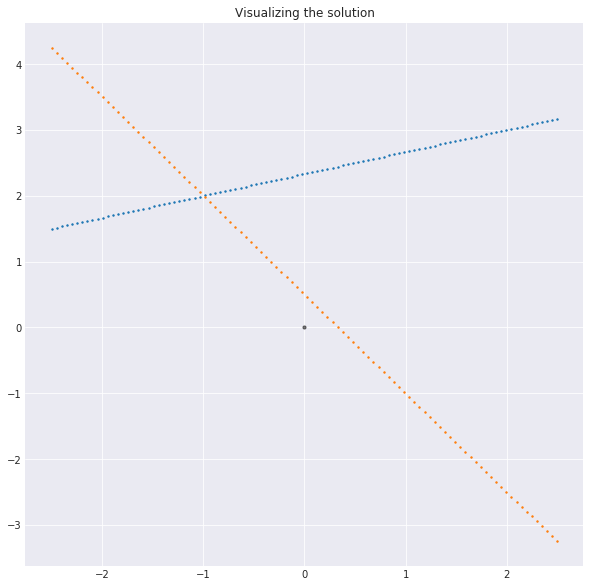

In [26]:
# plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('seaborn-darkgrid')

plt.scatter(x=xs, y = y1, s=2)
plt.scatter(x=xs, y = y2, s=2)
#plt.scatter(x=-1, y=2, color = 'r', marker='o', s=55)
plt.scatter(x=0, y=0, c='black', s=10, marker='o', alpha=.5)
plt.title("Visualizing the solution")
plt.show()

#### 두개의 1차 방정식을 그림으로 표현하면 만나는 지점에서 해를 구할수 있습니다. $\textbf{(-1,2)}$

## 2. 행열을 이용해서 풀어보겠습니다. 
Importantly, every linear transformation can be represented by a matrix, and every matrix defines a unique linear transformation. The proof is left as an exercise for the reader -- or you can just <a href="https://math.stackexchange.com/questions/916192/proving-any-linear-transformation-can-be-represented-as-a-matrix" target="_blank" rel="noopener noreferrer">read a nice one on math Stack Exchange</a>. 

Now let's solve this system with matrices in `TensorFlow`! `TensorFlow` makes  <a href="https://www.tensorflow.org/api_guides/python/math_ops" target="_blank" rel="noopener noreferrer">matrix math</a> easy.

First, we need to represent our system of equations in matrix form: 

$
  \left[ {\begin{array}{cc}
   -1 & 3 \\
   3 & 2 \\
  \end{array} } \right]
 $
 $
 \left[ {\begin{array}{c}
   x \\
   y \\
  \end{array} } \right]
  $
  $ =  \left[ {\begin{array}{c}
   7 \\
   1 \\
  \end{array} } \right]
  $
  

Now, we're interested in values for  $
 \left[ {\begin{array}{c}
   x \\
   y \\
  \end{array} } \right]
  $ that makes this statement true. 
  
  
Representing the above more simply as:

$$ AX = B $$ 

where: 


* $A$ is the matrix of coefficients

* $X$ is $x$ and $y$

* $B$ is the values from the right hand side

Then we can solve:
$$A^{-1}B = X$$

for X, the matrix representing the solution, the $(x,y)$ pair, to our system of equations.  Let's implement this in `TensorFlow`.

In [27]:
# import tensorflow
import tensorflow as tf

# make the matrices in numpy
A = np.matrix([
    [-1, 3],
    [3, 2]
]).astype('float64')

B = np.matrix([
    [7], [1]
]).astype('float64')

# convert to tensors
A_t = tf.convert_to_tensor(A)
B_t = tf.convert_to_tensor(B)

## the inverse, A^-1
A_inv = tf.matrix_inverse(A_t)

# the solution
X = tf.matmul(A_inv, B)

* X 값, 즉 해가 구해졌습니다만,  tensor는 바로 출력이 안됩니다.

In [28]:
X

<tf.Tensor 'MatMul_2:0' shape=(2, 1) dtype=float64>

* tensor는 initialize 하고 sess.run 해야 값을 출력해줍니다.  <a href="https://www.tensorflow.org/api_docs/python/tf/Session" target="_blank" rel="noopener noreferrer">Tensorflow session sample </a>.

In [30]:
# Let's start a session 
# initialize the variables

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(X))

[[-1.]
 [ 2.]]


* 1차방정식 2개를 그림으로 그려서 해를 구한것과 동일한 결과를 얻었습니다.  $\textbf{(-1, 2)}$. Pretty cool! 

## 3. 다항방정식 풀기 예제 - IBM manufacturing 

Suppose that IBM wants to manufacture three types of computers, models $X, Y, \text{ and } Z$. 
And suppose further that there are three facilities, `Bangalore` $B$, `Poughkeepsie` $P$, and `Rome` $R$. Each location has an associated resource allocation. **Our goal is find the combination of the number of computers to produce such that all available resources are consumed.** 

* $X$ costs 3 in $B$,  4 in $P$, and 5 in $R$
* $Y$ costs 2 in $B$,  5 in $P$, and 7 in $R$
* $Z$ costs 4 in $B$,  3 in $P$, and 6 in $R$

Further, each location only has so many resources available. `Bangalore` $B$, `Poughkeepsie` $P$, and `Rome` $R$ have $25, 31, 44$ resources respectively. 

Consider this table:

In [31]:
# pandas for DataFrame tabular representation 
import pandas as pd
df = pd.DataFrame(index = ["Bangalore", "Poughkeepsie", "Rome"], columns = ["X", "Y", "Z", "Resources"])
df.X = [3,4,5]
df.Y = [2,5,7]
df.Z = [4,3,6]
df.Resources = [25, 31, 44]
df

,X,Y,Z,Resources
Bangalore,3,2,4,25
Poughkeepsie,4,5,3,31
Rome,5,7,6,44


Our task is to use all of the resources at the facilities. Let's write this as a system of equations:

$$ 3x + 2y + 4z = 25 $$
$$ 4x + 5y + 3z = 31 $$
$$ 5x + 7y + 6z = 44 $$

Now, we can represent this in matrix form:



$
  \left[ {\begin{array}{ccc}
   3 & 2 & 4 \\
   4 & 5 & 3 \\
   5 & 7 & 6\\
  \end{array} } \right]
 $
 $
 \left[ {\begin{array}{c}
   x \\
   y \\
   z\\
  \end{array} } \right]
  $
  $ =  \left[ {\begin{array}{c}
   25 \\
   31 \\
   44\\
  \end{array} } \right]
  $
 
and solve. 

In [36]:
# import tensorflow
import tensorflow as tf

# make the matrices in numpy
A = np.matrix([
    [3,2,4],
    [4,5,3],
    [5,7,6]
]).astype('float64')

B = np.matrix([
    [25], [31], [44]
]).astype('float64')

# convert to tensors
A_t = tf.convert_to_tensor(A)
B_t = tf.convert_to_tensor(B)

## the inverse, A^-1
A_inv = tf.matrix_inverse(A_t)

# the solution
X = tf.matmul(A_inv, B)

# Let's start a session 
# initialize the variables

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print('A_t  \n ',sess.run(A_t))
    print('A_inv  \n ',sess.run(A_inv))
    print('X     \n',sess.run(X))

A_t  
  [[ 3.  2.  4.]
 [ 4.  5.  3.]
 [ 5.  7.  6.]]
A_inv  
  [[ 0.42857143  0.76190476 -0.66666667]
 [-0.42857143 -0.0952381   0.33333333]
 [ 0.14285714 -0.52380952  0.33333333]]
X     
 [[ 5.]
 [ 1.]
 [ 2.]]


That's the solution! $$ x = 5$$ $$ y = 1 $$ $$ z = 2 $$


Now that we understand some of the basics of matrix math and `TensorFlow`, we can implement more complex solutions to different problems. 

## 4.  `Sine` 함수를 그려보고 머신러닝의 시작으로 선형회귀에 도전해보겠습니다.  <a id="sine"></a>
Now, we're going to move to some more advanced features. 
In this part, we're going to model a noisy sine curve. First, let's generate and visualize some synthetic data. 
* sine 곡선과 noize 에 해당하는 scatter 점들을 그려봅니다.

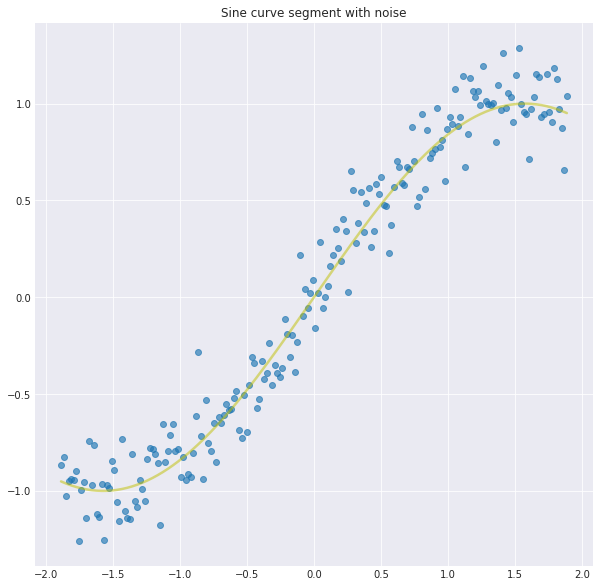

In [51]:
xs = np.linspace(-.6*np.pi, .6*np.pi,200)
y1 = [np.sin(i) + .15*np.random.randn() for i in xs]
y2 = np.sin(xs)
plt.scatter(xs,y1,alpha=.65)
plt.plot(xs,y2, c='y', linewidth=2.5, alpha=.5)
plt.title("Sine curve segment with noise")
plt.show()

In [52]:
xs

array([-1.88495559, -1.86601131, -1.84706704, -1.82812276, -1.80917848,
       -1.79023421, -1.77128993, -1.75234565, -1.73340137, -1.7144571 ,
       -1.69551282, -1.67656854, -1.65762426, -1.63867999, -1.61973571,
       -1.60079143, -1.58184716, -1.56290288, -1.5439586 , -1.52501432,
       -1.50607005, -1.48712577, -1.46818149, -1.44923721, -1.43029294,
       -1.41134866, -1.39240438, -1.3734601 , -1.35451583, -1.33557155,
       -1.31662727, -1.297683  , -1.27873872, -1.25979444, -1.24085016,
       -1.22190589, -1.20296161, -1.18401733, -1.16507305, -1.14612878,
       -1.1271845 , -1.10824022, -1.08929595, -1.07035167, -1.05140739,
       -1.03246311, -1.01351884, -0.99457456, -0.97563028, -0.956686  ,
       -0.93774173, -0.91879745, -0.89985317, -0.88090889, -0.86196462,
       -0.84302034, -0.82407606, -0.80513179, -0.78618751, -0.76724323,
       -0.74829895, -0.72935468, -0.7104104 , -0.69146612, -0.67252184,
       -0.65357757, -0.63463329, -0.61568901, -0.59674474, -0.57

Our goal is to build a **linear model** of the form $Y = WX + B$ that best approximates the  curve.

*  <a href="https://www.tensorflow.org/api_docs/python/tf/placeholder" target="_blank" rel="noopener noreferrer">placeholders</a>를 정의하면 나중에 x,y 값을 feeding 시킬수가 있습니다.

In [53]:
x = tf.placeholder(tf.float64, name="x_data")
y = tf.placeholder(tf.float64, name="y_data")

We're trying to learn the values for $W$ and $B$ which minimize the square of the difference between our model's _predicted `y`_ value and the _actual `y`_ value. To accomplish this, we'll need to create a variable which stores these 2 values. We initialize this with random values. 

In [54]:
V = tf.Variable(tf.random_normal(shape=[2,1], dtype=tf.float64), name="values", dtype=tf.float64)

We're building a linear model. The steps we'll use are:
1. Multiply the weights matrix, $V[0]$ by the $x$ value, and add the bias $V[1]$
2. Calculate the error 
3. Optimize the weights with `Gradient Descent`  

In [55]:
# linear model of the form y = wx + b
predicted_y = tf.multiply(x, V[0]) + V[1]

The learning algorithm we're going to use is  <a href="https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer" target="_blank" rel="noopener noreferrer">Gradient Descent</a>. This algorithm will attempt to minimize the value produced by our error function, in our case it will be  the square of the difference between our model's predicted y value and the actual y value. 
* err 을 cost function 이라고도 합니다. 즉 cost 를 최소화 할수 있는 W,b 를 구하는 게 목적입니다.

In [56]:
err = tf.squared_difference(y, predicted_y)

We define the optimization. 

In [57]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(err)

Just as before, we're going to initialize the varibales. 

In [58]:
init = tf.global_variables_initializer()

* 이제 모델을 trainning 시켜서 W,b 값을 구합니다.

In [59]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(2500):
        x_data = xs[i%len(xs)]
        y_data = y1[i%len(xs)]
        # run the training step
        sess.run(train, feed_dict={x:x_data, y:y_data})
        
        # check the weights every 100 iterations
        if i%500==0: 
            print(sess.run(V))
            # periodically assign to a normal python variable for use in the graph
            v = sess.run(V)
            

[[-0.36107305]
 [ 1.49507915]]
[[ 0.69836861]
 [-0.09758897]]
[[ 0.60320973]
 [-0.02678789]]
[[ 0.68822563]
 [-0.10406518]]
[[ 0.60316949]
 [-0.02672202]]


Cool, now we've got a linear model close to $$ y = 0.605x - 0.022 $$ Let's plot this. 

In [60]:
v

array([[ 0.60316949],
       [-0.02672202]])

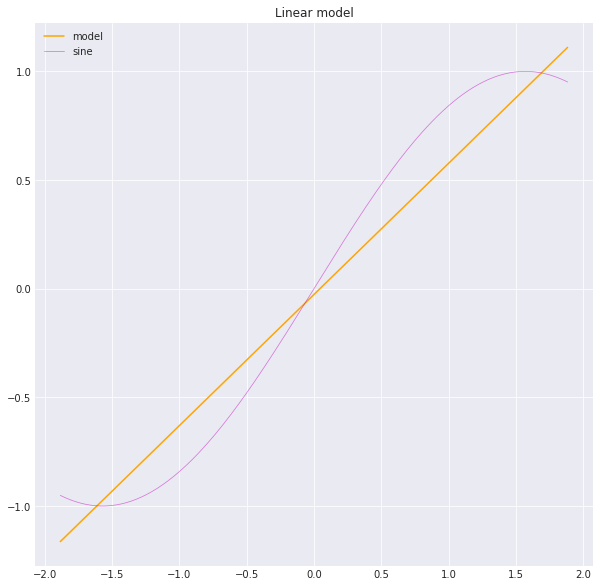

In [61]:
model_values = [(i*v[0] + v[1]) for i in xs]

plt.title("Linear model")
plt.plot(xs, model_values, linewidth=1.5, c='orange', label='model')
plt.plot(xs,y2, c='m', linewidth=.75, alpha=.5, label='sine')
plt.legend()
plt.show()

## 4. 여러분은 이제 막 `Linear Regression` in `Tensorflow`를 실습했습니다.

***`이렇게 선형 함수를 그렸다는 것은 x 값이 주어지면, y값을 예측할 수 있다는 뜻입니다.`


You might not have realized it, but we just implemented `Linear Regression` in `TensorFlow`! The steps we used above can be generalized to other dimensions for $x$. 

Just as we generalized with the matrix math to a real world example, I encourage you to use the above blueprint for your linear regressions. Compare the results to other methods implemented in popular frameworks like python's `scikit-learn` or linear models in `R`. It's fun to generate a plot from the model's weights as the model is training. 

Another exercise you might consider is putting this code in the iteration loop. 

Look forward to part two, we're going to build a neural network that more accurately approximates a `Sine` curve.

__________
### Author
Adam Massachi is a Data Scientist with the Watson Studio and Watson Data Platform teams at IBM. Before IBM, he worked on political campaigns, building and managing large volunteer operations and organizing campaign finance initiatives. Say hello @adammassach!

### Citations
${[1]}$ http://mathworld.wolfram.com/Tensor.html
<br>
${[2]}$ https://www.tensorflow.org/versions/r0.12/get_started/basic_usage#tensors
<hr>

Copyright &copy; IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.